<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle


In [3]:
! cp kaggle.json ~/.kaggle/


In [4]:
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:32<00:00, 195MB/s]
100% 5.20G/5.20G [00:32<00:00, 170MB/s]


In [6]:
! unzip skin-cancer-mnist-ham10000.zip


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax , Ftrl , Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/HAM10000/', '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}                     

In [3]:
skin_df = pd.read_csv(os.path.join( '/content/HAM10000/HAM10000_metadata.csv'))


In [4]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000/HAM10000_images_part_2/ISIC_...,Benign keratosis-like lesions,2


In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

In [7]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [8]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [9]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [10]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [11]:
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))

In [12]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Fitting the model using Adam

In [13]:
from tensorflow.keras.layers import LeakyReLU, Dense
act = LeakyReLU()

In [14]:

input_shape = (32, 32, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation=act,padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation=act,padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation=act,padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation=act))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [15]:



filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [19]:
# Define the optimizer
optimizer = Adam(learning_rate=0.1)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 50 
batch_size = 64
history_01= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint])

Epoch 1/50


<ipython-input-19-71f99dd405d5>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_01= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


111/112 [============================>.] - ETA: 0s - loss: 9150211.0000 - accuracy: 0.5097

112/112 [==============================] - 5s 42ms/step - loss: 9070450.0000 - accuracy: 0.5099 - val_loss: 205287.1875 - val_accuracy: 0.6334
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 106233.8359 - accuracy: 0.5418

112/112 [==============================] - 5s 47ms/step - loss: 106183.3359 - accuracy: 0.5410 - val_loss: 114275.3906 - val_accuracy: 0.4140
Epoch 3/50
111/112 [============================>.] - ETA: 0s - loss: 50455.5625 - accuracy: 0.5487

112/112 [==============================] - 5s 44ms/step - loss: 50265.5820 - accuracy: 0.5490 - val_loss: 16233.4219 - val_accuracy: 0.6234
Epoch 4/50
111/112 [============================>.] - ETA: 0s - loss: 27303.7949 - accuracy: 0.5566

112/112 [==============================] - 5s 44ms/step - loss: 27345.6016 - accuracy: 0.5557 - val_loss: 14087.2900 - val_accuracy: 0.6334
Epoch 5/50
111/112 [============================>.] - ETA: 0s - loss: 24744.8633 - accuracy: 0.5391

112/112 [==============================] - 4s 38ms/step - loss: 24669.6289 - accuracy: 0.5385 - val_loss: 14030.5898 - val_accuracy: 0.5998
Epoch 6/50
112/112 [==============================] - ETA: 0s - loss: 16295.7832 - accuracy: 0.5514

112/112 [==============================] - 5s 47ms/step - loss: 16295.7832 - accuracy: 0.5514 - val_loss: 6197.2383 - val_accuracy: 0.5823
Epoch 7/50
111/112 [============================>.] - ETA: 0s - loss: 12922.2051 - accuracy: 0.5428

112/112 [==============================] - 4s 36ms/step - loss: 12938.3770 - accuracy: 0.5430 - val_loss: 5539.9956 - val_accuracy: 0.6484
Epoch 8/50
112/112 [==============================] - ETA: 0s - loss: 9763.0996 - accuracy: 0.5462

112/112 [==============================] - 5s 46ms/step - loss: 9763.0996 - accuracy: 0.5462 - val_loss: 16252.5498 - val_accuracy: 0.4825
Epoch 9/50
112/112 [==============================] - ETA: 0s - loss: 13160.4844 - accuracy: 0.5281

112/112 [==============================] - 6s 51ms/step - loss: 13160.4844 - accuracy: 0.5281 - val_loss: 4199.9761 - val_accuracy: 0.6297
Epoch 10/50
112/112 [==============================] - ETA: 0s - loss: 10542.0635 - accuracy: 0.5476

112/112 [==============================] - 7s 59ms/step - loss: 10542.0635 - accuracy: 0.5476 - val_loss: 39102.3359 - val_accuracy: 0.6434
Epoch 11/50
112/112 [==============================] - ETA: 0s - loss: 14607.7080 - accuracy: 0.5239

112/112 [==============================] - 5s 41ms/step - loss: 14607.7080 - accuracy: 0.5239 - val_loss: 3834.2297 - val_accuracy: 0.6446
Epoch 12/50
111/112 [============================>.] - ETA: 0s - loss: 5672.0815 - accuracy: 0.5432

112/112 [==============================] - 4s 35ms/step - loss: 5679.3545 - accuracy: 0.5435 - val_loss: 2986.8171 - val_accuracy: 0.6434
Epoch 13/50
111/112 [============================>.] - ETA: 0s - loss: 4316.0547 - accuracy: 0.5510

112/112 [==============================] - 4s 36ms/step - loss: 4297.6313 - accuracy: 0.5511 - val_loss: 3044.1250 - val_accuracy: 0.6509
Epoch 14/50
111/112 [============================>.] - ETA: 0s - loss: 4614.0513 - accuracy: 0.5419

112/112 [==============================] - 4s 35ms/step - loss: 4625.0093 - accuracy: 0.5406 - val_loss: 3652.3774 - val_accuracy: 0.6185
Epoch 15/50
111/112 [============================>.] - ETA: 0s - loss: 7976.8623 - accuracy: 0.5360

112/112 [==============================] - 4s 36ms/step - loss: 7941.5762 - accuracy: 0.5364 - val_loss: 2582.0234 - val_accuracy: 0.6172
Epoch 16/50
112/112 [==============================] - ETA: 0s - loss: 3736.4946 - accuracy: 0.5578

112/112 [==============================] - 4s 36ms/step - loss: 3736.4946 - accuracy: 0.5578 - val_loss: 3560.7053 - val_accuracy: 0.6322
Epoch 17/50
111/112 [============================>.] - ETA: 0s - loss: 3599.5300 - accuracy: 0.5425

112/112 [==============================] - 4s 36ms/step - loss: 3597.3137 - accuracy: 0.5417 - val_loss: 3461.0632 - val_accuracy: 0.5998
Epoch 18/50
111/112 [============================>.] - ETA: 0s - loss: 2772.5493 - accuracy: 0.5366

112/112 [==============================] - 4s 35ms/step - loss: 2767.9514 - accuracy: 0.5365 - val_loss: 1802.2909 - val_accuracy: 0.6509
Epoch 19/50
112/112 [==============================] - ETA: 0s - loss: 4543.9189 - accuracy: 0.5259

112/112 [==============================] - 4s 36ms/step - loss: 4543.9189 - accuracy: 0.5259 - val_loss: 3127.1792 - val_accuracy: 0.5998
Epoch 20/50
111/112 [============================>.] - ETA: 0s - loss: 2789.7458 - accuracy: 0.5450

112/112 [==============================] - 5s 44ms/step - loss: 2795.4766 - accuracy: 0.5442 - val_loss: 3482.3523 - val_accuracy: 0.5648
Epoch 21/50
111/112 [============================>.] - ETA: 0s - loss: 3802.6470 - accuracy: 0.5203

112/112 [==============================] - 4s 36ms/step - loss: 3783.0676 - accuracy: 0.5209 - val_loss: 2953.6179 - val_accuracy: 0.6384
Epoch 22/50
111/112 [============================>.] - ETA: 0s - loss: 2082.2507 - accuracy: 0.5435

112/112 [==============================] - 4s 35ms/step - loss: 2072.8977 - accuracy: 0.5435 - val_loss: 885.5836 - val_accuracy: 0.5998
Epoch 23/50
111/112 [============================>.] - ETA: 0s - loss: 13088.2334 - accuracy: 0.5127

112/112 [==============================] - 4s 35ms/step - loss: 13033.8643 - accuracy: 0.5125 - val_loss: 5034.9180 - val_accuracy: 0.5474
Epoch 24/50
111/112 [============================>.] - ETA: 0s - loss: 3053.9546 - accuracy: 0.5295

112/112 [==============================] - 4s 36ms/step - loss: 3053.6772 - accuracy: 0.5304 - val_loss: 1734.7577 - val_accuracy: 0.5436
Epoch 25/50
111/112 [============================>.] - ETA: 0s - loss: 1951.0159 - accuracy: 0.5219

112/112 [==============================] - 4s 35ms/step - loss: 1968.0902 - accuracy: 0.5229 - val_loss: 2017.2831 - val_accuracy: 0.6434
Epoch 26/50
111/112 [============================>.] - ETA: 0s - loss: 1297.0715 - accuracy: 0.5515

112/112 [==============================] - 4s 36ms/step - loss: 1291.4581 - accuracy: 0.5522 - val_loss: 927.8398 - val_accuracy: 0.6372
Epoch 27/50
111/112 [============================>.] - ETA: 0s - loss: 1494.5461 - accuracy: 0.5301

112/112 [==============================] - 4s 36ms/step - loss: 1490.1403 - accuracy: 0.5295 - val_loss: 1376.2360 - val_accuracy: 0.6284
Epoch 28/50
111/112 [============================>.] - ETA: 0s - loss: 1695.2784 - accuracy: 0.5350

112/112 [==============================] - 4s 37ms/step - loss: 1683.3566 - accuracy: 0.5357 - val_loss: 1272.1300 - val_accuracy: 0.6434
Epoch 29/50
111/112 [============================>.] - ETA: 0s - loss: 1084.7382 - accuracy: 0.5452

112/112 [==============================] - 4s 35ms/step - loss: 1078.0122 - accuracy: 0.5451 - val_loss: 490.9701 - val_accuracy: 0.6234
Epoch 30/50
111/112 [============================>.] - ETA: 0s - loss: 1527.9307 - accuracy: 0.5367

112/112 [==============================] - 4s 36ms/step - loss: 1522.7761 - accuracy: 0.5367 - val_loss: 1733.5161 - val_accuracy: 0.6284
Epoch 31/50
111/112 [============================>.] - ETA: 0s - loss: 1692.8151 - accuracy: 0.5271

112/112 [==============================] - 4s 35ms/step - loss: 1719.2306 - accuracy: 0.5278 - val_loss: 7217.9658 - val_accuracy: 0.6397
Epoch 32/50
111/112 [============================>.] - ETA: 0s - loss: 2531.4326 - accuracy: 0.5306

112/112 [==============================] - 4s 36ms/step - loss: 2518.6101 - accuracy: 0.5311 - val_loss: 671.0042 - val_accuracy: 0.6559
Epoch 33/50
111/112 [============================>.] - ETA: 0s - loss: 1525.8252 - accuracy: 0.5261

112/112 [==============================] - 4s 36ms/step - loss: 1523.0048 - accuracy: 0.5266 - val_loss: 1555.2393 - val_accuracy: 0.6434
Epoch 34/50
111/112 [============================>.] - ETA: 0s - loss: 1148.6162 - accuracy: 0.5374

112/112 [==============================] - 4s 36ms/step - loss: 1141.7533 - accuracy: 0.5372 - val_loss: 1084.7823 - val_accuracy: 0.6334
Epoch 35/50
111/112 [============================>.] - ETA: 0s - loss: 1569.0547 - accuracy: 0.5216

112/112 [==============================] - 4s 35ms/step - loss: 1573.6860 - accuracy: 0.5225 - val_loss: 824.8815 - val_accuracy: 0.6397
Epoch 36/50
111/112 [============================>.] - ETA: 0s - loss: 2382.6350 - accuracy: 0.5178

112/112 [==============================] - 4s 36ms/step - loss: 2406.8391 - accuracy: 0.5164 - val_loss: 2721.5818 - val_accuracy: 0.6309
Epoch 37/50
111/112 [============================>.] - ETA: 0s - loss: 1642.6204 - accuracy: 0.5310

112/112 [==============================] - 4s 35ms/step - loss: 1634.9500 - accuracy: 0.5321 - val_loss: 912.8959 - val_accuracy: 0.6085
Epoch 38/50
111/112 [============================>.] - ETA: 0s - loss: 1414.3773 - accuracy: 0.5249

112/112 [==============================] - 4s 36ms/step - loss: 1410.6761 - accuracy: 0.5257 - val_loss: 1450.6744 - val_accuracy: 0.6421
Epoch 39/50
111/112 [============================>.] - ETA: 0s - loss: 2023.6199 - accuracy: 0.5199

112/112 [==============================] - 4s 35ms/step - loss: 2016.5350 - accuracy: 0.5193 - val_loss: 1555.4109 - val_accuracy: 0.6434
Epoch 40/50
112/112 [==============================] - ETA: 0s - loss: 1116.7197 - accuracy: 0.5402

112/112 [==============================] - 4s 36ms/step - loss: 1116.7197 - accuracy: 0.5402 - val_loss: 2092.3667 - val_accuracy: 0.5574
Epoch 41/50
112/112 [==============================] - ETA: 0s - loss: 132635860992.0000 - accuracy: 0.4503

112/112 [==============================] - 4s 37ms/step - loss: 132635860992.0000 - accuracy: 0.4503 - val_loss: 26012602368.0000 - val_accuracy: 0.5698
Epoch 42/50
111/112 [============================>.] - ETA: 0s - loss: 7204926464.0000 - accuracy: 0.5161

112/112 [==============================] - 4s 35ms/step - loss: 7163896832.0000 - accuracy: 0.5169 - val_loss: 1703500928.0000 - val_accuracy: 0.6384
Epoch 43/50
111/112 [============================>.] - ETA: 0s - loss: 1073868672.0000 - accuracy: 0.5497

112/112 [==============================] - 4s 36ms/step - loss: 1072278336.0000 - accuracy: 0.5486 - val_loss: 462303488.0000 - val_accuracy: 0.5549
Epoch 44/50
111/112 [============================>.] - ETA: 0s - loss: 565210624.0000 - accuracy: 0.5551

112/112 [==============================] - 4s 36ms/step - loss: 563547008.0000 - accuracy: 0.5553 - val_loss: 324758112.0000 - val_accuracy: 0.5661
Epoch 45/50
111/112 [============================>.] - ETA: 0s - loss: 424516416.0000 - accuracy: 0.5521

112/112 [==============================] - 4s 36ms/step - loss: 424072544.0000 - accuracy: 0.5525 - val_loss: 171404480.0000 - val_accuracy: 0.5935
Epoch 46/50
111/112 [============================>.] - ETA: 0s - loss: 329165632.0000 - accuracy: 0.5438

112/112 [==============================] - 4s 36ms/step - loss: 328358112.0000 - accuracy: 0.5441 - val_loss: 132789512.0000 - val_accuracy: 0.5998
Epoch 47/50
111/112 [============================>.] - ETA: 0s - loss: 248919168.0000 - accuracy: 0.5508

112/112 [==============================] - 4s 35ms/step - loss: 249011504.0000 - accuracy: 0.5509 - val_loss: 178911584.0000 - val_accuracy: 0.6434
Epoch 48/50
111/112 [============================>.] - ETA: 0s - loss: 209648720.0000 - accuracy: 0.5530

112/112 [==============================] - 4s 36ms/step - loss: 210148688.0000 - accuracy: 0.5525 - val_loss: 156601280.0000 - val_accuracy: 0.6434
Epoch 49/50
111/112 [============================>.] - ETA: 0s - loss: 168377936.0000 - accuracy: 0.5554

112/112 [==============================] - 4s 35ms/step - loss: 168243872.0000 - accuracy: 0.5546 - val_loss: 101173640.0000 - val_accuracy: 0.6222
Epoch 50/50
111/112 [============================>.] - ETA: 0s - loss: 134134000.0000 - accuracy: 0.5506

112/112 [==============================] - 4s 36ms/step - loss: 133858200.0000 - accuracy: 0.5505 - val_loss: 114233392.0000 - val_accuracy: 0.6384


In [20]:
# Define the optimizer
optimizer = Adam(learning_rate=0.01)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 50 
batch_size = 64
history_001= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint])

Epoch 1/50


<ipython-input-20-ba94a245dfd9>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_001= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


111/112 [============================>.] - ETA: 0s - loss: 149755104.0000 - accuracy: 0.5425

112/112 [==============================] - 5s 37ms/step - loss: 149052688.0000 - accuracy: 0.5430 - val_loss: 47482700.0000 - val_accuracy: 0.6384
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 67944736.0000 - accuracy: 0.5515

112/112 [==============================] - 4s 36ms/step - loss: 67842448.0000 - accuracy: 0.5516 - val_loss: 39222816.0000 - val_accuracy: 0.6297
Epoch 3/50
111/112 [============================>.] - ETA: 0s - loss: 47367304.0000 - accuracy: 0.5517

112/112 [==============================] - 4s 35ms/step - loss: 47510032.0000 - accuracy: 0.5518 - val_loss: 33355700.0000 - val_accuracy: 0.6372
Epoch 4/50
111/112 [============================>.] - ETA: 0s - loss: 33960620.0000 - accuracy: 0.5503

112/112 [==============================] - 4s 36ms/step - loss: 34016432.0000 - accuracy: 0.5494 - val_loss: 24035668.0000 - val_accuracy: 0.6421
Epoch 5/50
111/112 [============================>.] - ETA: 0s - loss: 32746258.0000 - accuracy: 0.5469

112/112 [==============================] - 4s 36ms/step - loss: 32550206.0000 - accuracy: 0.5483 - val_loss: 18174036.0000 - val_accuracy: 0.6446
Epoch 6/50
111/112 [============================>.] - ETA: 0s - loss: 21260546.0000 - accuracy: 0.5555

112/112 [==============================] - 4s 36ms/step - loss: 21206766.0000 - accuracy: 0.5560 - val_loss: 9978153.0000 - val_accuracy: 0.6372
Epoch 7/50
111/112 [============================>.] - ETA: 0s - loss: 16649833.0000 - accuracy: 0.5486

112/112 [==============================] - 4s 36ms/step - loss: 16641595.0000 - accuracy: 0.5474 - val_loss: 14634716.0000 - val_accuracy: 0.6397
Epoch 8/50
111/112 [============================>.] - ETA: 0s - loss: 14242139.0000 - accuracy: 0.5546

112/112 [==============================] - 4s 36ms/step - loss: 14278360.0000 - accuracy: 0.5542 - val_loss: 9594256.0000 - val_accuracy: 0.6459
Epoch 9/50
111/112 [============================>.] - ETA: 0s - loss: 12382968.0000 - accuracy: 0.5421

112/112 [==============================] - 4s 36ms/step - loss: 12390598.0000 - accuracy: 0.5423 - val_loss: 4286696.5000 - val_accuracy: 0.6521
Epoch 10/50
111/112 [============================>.] - ETA: 0s - loss: 9631646.0000 - accuracy: 0.5528

112/112 [==============================] - 4s 36ms/step - loss: 9598147.0000 - accuracy: 0.5530 - val_loss: 5638806.5000 - val_accuracy: 0.6509
Epoch 11/50
112/112 [==============================] - ETA: 0s - loss: 8682592.0000 - accuracy: 0.5383

112/112 [==============================] - 4s 36ms/step - loss: 8682592.0000 - accuracy: 0.5383 - val_loss: 7871995.0000 - val_accuracy: 0.6234
Epoch 12/50
111/112 [============================>.] - ETA: 0s - loss: 7423576.0000 - accuracy: 0.5339

112/112 [==============================] - 4s 36ms/step - loss: 7390148.5000 - accuracy: 0.5334 - val_loss: 2661256.5000 - val_accuracy: 0.6234
Epoch 13/50
111/112 [============================>.] - ETA: 0s - loss: 6526485.5000 - accuracy: 0.5414

112/112 [==============================] - 4s 36ms/step - loss: 6523012.5000 - accuracy: 0.5425 - val_loss: 7167721.0000 - val_accuracy: 0.6209
Epoch 14/50
111/112 [============================>.] - ETA: 0s - loss: 6423741.0000 - accuracy: 0.5453

112/112 [==============================] - 4s 35ms/step - loss: 6428300.0000 - accuracy: 0.5462 - val_loss: 4008777.0000 - val_accuracy: 0.6259
Epoch 15/50
111/112 [============================>.] - ETA: 0s - loss: 5883849.5000 - accuracy: 0.5378

112/112 [==============================] - 5s 44ms/step - loss: 5882413.0000 - accuracy: 0.5371 - val_loss: 4427869.0000 - val_accuracy: 0.5773
Epoch 16/50
111/112 [============================>.] - ETA: 0s - loss: 4836956.5000 - accuracy: 0.5376

112/112 [==============================] - 4s 35ms/step - loss: 4836337.5000 - accuracy: 0.5382 - val_loss: 3019436.7500 - val_accuracy: 0.6147
Epoch 17/50
111/112 [============================>.] - ETA: 0s - loss: 5666425.5000 - accuracy: 0.5223

112/112 [==============================] - 4s 35ms/step - loss: 5635564.0000 - accuracy: 0.5236 - val_loss: 3950594.0000 - val_accuracy: 0.5923
Epoch 18/50
111/112 [============================>.] - ETA: 0s - loss: 3236169.5000 - accuracy: 0.5479

112/112 [==============================] - 4s 35ms/step - loss: 3234181.7500 - accuracy: 0.5469 - val_loss: 1580562.0000 - val_accuracy: 0.6185
Epoch 19/50
111/112 [============================>.] - ETA: 0s - loss: 3084286.7500 - accuracy: 0.5429

112/112 [==============================] - 4s 36ms/step - loss: 3076613.5000 - accuracy: 0.5434 - val_loss: 1876157.5000 - val_accuracy: 0.5424
Epoch 20/50
111/112 [============================>.] - ETA: 0s - loss: 3193944.2500 - accuracy: 0.5318

112/112 [==============================] - 4s 35ms/step - loss: 3190938.2500 - accuracy: 0.5325 - val_loss: 2179423.5000 - val_accuracy: 0.6309
Epoch 21/50
111/112 [============================>.] - ETA: 0s - loss: 2555522.0000 - accuracy: 0.5491

112/112 [==============================] - 4s 36ms/step - loss: 2582373.7500 - accuracy: 0.5495 - val_loss: 4217428.0000 - val_accuracy: 0.6060
Epoch 22/50
111/112 [============================>.] - ETA: 0s - loss: 2389584.0000 - accuracy: 0.5438

112/112 [==============================] - 4s 35ms/step - loss: 2386320.7500 - accuracy: 0.5435 - val_loss: 1460590.5000 - val_accuracy: 0.6259
Epoch 23/50
111/112 [============================>.] - ETA: 0s - loss: 1526818.0000 - accuracy: 0.5480

112/112 [==============================] - 4s 35ms/step - loss: 1523990.6250 - accuracy: 0.5476 - val_loss: 1367870.7500 - val_accuracy: 0.6209
Epoch 24/50
111/112 [============================>.] - ETA: 0s - loss: 1435080.7500 - accuracy: 0.5609

112/112 [==============================] - 4s 35ms/step - loss: 1429632.2500 - accuracy: 0.5605 - val_loss: 1069383.0000 - val_accuracy: 0.6446
Epoch 25/50
111/112 [============================>.] - ETA: 0s - loss: 1492668.8750 - accuracy: 0.5470

112/112 [==============================] - 4s 36ms/step - loss: 1485637.2500 - accuracy: 0.5477 - val_loss: 872796.5625 - val_accuracy: 0.5449
Epoch 26/50
111/112 [============================>.] - ETA: 0s - loss: 1240032.8750 - accuracy: 0.5404

112/112 [==============================] - 4s 35ms/step - loss: 1244008.2500 - accuracy: 0.5396 - val_loss: 1197941.5000 - val_accuracy: 0.6434
Epoch 27/50
111/112 [============================>.] - ETA: 0s - loss: 1514665.7500 - accuracy: 0.5422

112/112 [==============================] - 4s 36ms/step - loss: 1508576.7500 - accuracy: 0.5425 - val_loss: 836930.9375 - val_accuracy: 0.6347
Epoch 28/50
111/112 [============================>.] - ETA: 0s - loss: 936344.1250 - accuracy: 0.5450

112/112 [==============================] - 4s 36ms/step - loss: 930309.5000 - accuracy: 0.5458 - val_loss: 427838.1250 - val_accuracy: 0.6434
Epoch 29/50
111/112 [============================>.] - ETA: 0s - loss: 830900.8750 - accuracy: 0.5517

112/112 [==============================] - 4s 35ms/step - loss: 830755.3750 - accuracy: 0.5518 - val_loss: 511949.7188 - val_accuracy: 0.6010
Epoch 30/50
111/112 [============================>.] - ETA: 0s - loss: 758800.4375 - accuracy: 0.5364

112/112 [==============================] - 4s 35ms/step - loss: 757340.8750 - accuracy: 0.5369 - val_loss: 527290.7500 - val_accuracy: 0.6359
Epoch 31/50
111/112 [============================>.] - ETA: 0s - loss: 727004.1875 - accuracy: 0.5431

112/112 [==============================] - 4s 35ms/step - loss: 723930.0000 - accuracy: 0.5428 - val_loss: 638846.1250 - val_accuracy: 0.6459
Epoch 32/50
111/112 [============================>.] - ETA: 0s - loss: 555368.1250 - accuracy: 0.5377

112/112 [==============================] - 4s 36ms/step - loss: 554871.6250 - accuracy: 0.5383 - val_loss: 806034.8125 - val_accuracy: 0.6259
Epoch 33/50
111/112 [============================>.] - ETA: 0s - loss: 569736.3750 - accuracy: 0.5371

112/112 [==============================] - 4s 35ms/step - loss: 567014.1250 - accuracy: 0.5358 - val_loss: 322448.9688 - val_accuracy: 0.6147
Epoch 34/50
111/112 [============================>.] - ETA: 0s - loss: 415160.1875 - accuracy: 0.5556

112/112 [==============================] - 4s 36ms/step - loss: 413129.4688 - accuracy: 0.5567 - val_loss: 347699.6250 - val_accuracy: 0.6185
Epoch 35/50
111/112 [============================>.] - ETA: 0s - loss: 432976.6562 - accuracy: 0.5311

112/112 [==============================] - 4s 35ms/step - loss: 431373.4062 - accuracy: 0.5323 - val_loss: 265737.3125 - val_accuracy: 0.4913
Epoch 36/50
111/112 [============================>.] - ETA: 0s - loss: 348762.1250 - accuracy: 0.5328

112/112 [==============================] - 4s 35ms/step - loss: 348803.3438 - accuracy: 0.5330 - val_loss: 404004.8125 - val_accuracy: 0.6359
Epoch 37/50
111/112 [============================>.] - ETA: 0s - loss: 339878.2500 - accuracy: 0.5373

112/112 [==============================] - 4s 36ms/step - loss: 339709.0312 - accuracy: 0.5362 - val_loss: 192267.7656 - val_accuracy: 0.6397
Epoch 38/50
111/112 [============================>.] - ETA: 0s - loss: 337387.7188 - accuracy: 0.5335

112/112 [==============================] - 4s 36ms/step - loss: 337654.7500 - accuracy: 0.5339 - val_loss: 375655.6562 - val_accuracy: 0.6434
Epoch 39/50
111/112 [============================>.] - ETA: 0s - loss: 234422.3281 - accuracy: 0.5452

112/112 [==============================] - 4s 36ms/step - loss: 235303.1406 - accuracy: 0.5453 - val_loss: 136516.4062 - val_accuracy: 0.6085
Epoch 40/50
111/112 [============================>.] - ETA: 0s - loss: 503612.8125 - accuracy: 0.5306

112/112 [==============================] - 4s 36ms/step - loss: 530212.9375 - accuracy: 0.5298 - val_loss: 4230955.0000 - val_accuracy: 0.6459
Epoch 41/50
111/112 [============================>.] - ETA: 0s - loss: 898067.3750 - accuracy: 0.5460

112/112 [==============================] - 4s 36ms/step - loss: 892004.1875 - accuracy: 0.5466 - val_loss: 241025.8750 - val_accuracy: 0.5885
Epoch 42/50
111/112 [============================>.] - ETA: 0s - loss: 237132.4219 - accuracy: 0.5459

112/112 [==============================] - 4s 36ms/step - loss: 236495.5156 - accuracy: 0.5456 - val_loss: 135752.9688 - val_accuracy: 0.6509
Epoch 43/50
112/112 [==============================] - ETA: 0s - loss: 164375.7344 - accuracy: 0.5494

112/112 [==============================] - 4s 37ms/step - loss: 164375.7344 - accuracy: 0.5494 - val_loss: 101164.5781 - val_accuracy: 0.6421
Epoch 44/50
111/112 [============================>.] - ETA: 0s - loss: 125231.1562 - accuracy: 0.5515

112/112 [==============================] - 4s 35ms/step - loss: 124796.7500 - accuracy: 0.5522 - val_loss: 79555.6562 - val_accuracy: 0.4177
Epoch 45/50
111/112 [============================>.] - ETA: 0s - loss: 93595.0000 - accuracy: 0.5537

112/112 [==============================] - 4s 37ms/step - loss: 93540.0000 - accuracy: 0.5526 - val_loss: 88641.4531 - val_accuracy: 0.6359
Epoch 46/50
111/112 [============================>.] - ETA: 0s - loss: 88185.6406 - accuracy: 0.5566

112/112 [==============================] - 4s 36ms/step - loss: 87997.4531 - accuracy: 0.5564 - val_loss: 54668.3594 - val_accuracy: 0.6222
Epoch 47/50
112/112 [==============================] - ETA: 0s - loss: 74249.7422 - accuracy: 0.5474

112/112 [==============================] - 4s 37ms/step - loss: 74249.7422 - accuracy: 0.5474 - val_loss: 42937.7109 - val_accuracy: 0.5536
Epoch 48/50
111/112 [============================>.] - ETA: 0s - loss: 63055.4805 - accuracy: 0.5503

112/112 [==============================] - 4s 36ms/step - loss: 63151.8672 - accuracy: 0.5500 - val_loss: 84195.8672 - val_accuracy: 0.6384
Epoch 49/50
111/112 [============================>.] - ETA: 0s - loss: 60123.9180 - accuracy: 0.5511

112/112 [==============================] - 4s 35ms/step - loss: 60078.1914 - accuracy: 0.5519 - val_loss: 69820.2266 - val_accuracy: 0.4813
Epoch 50/50
111/112 [============================>.] - ETA: 0s - loss: 55516.1914 - accuracy: 0.5455

112/112 [==============================] - 4s 35ms/step - loss: 55488.9688 - accuracy: 0.5449 - val_loss: 34949.6875 - val_accuracy: 0.6347


In [21]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 50 
batch_size = 64
history_0001= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint])

Epoch 1/50


<ipython-input-21-b7b2143ba59e>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_0001= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


111/112 [============================>.] - ETA: 0s - loss: 35272.1055 - accuracy: 0.5541

112/112 [==============================] - 5s 38ms/step - loss: 35626.9141 - accuracy: 0.5542 - val_loss: 23017.4355 - val_accuracy: 0.5536
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 25180.2676 - accuracy: 0.5441

112/112 [==============================] - 4s 35ms/step - loss: 25089.2559 - accuracy: 0.5435 - val_loss: 26668.3906 - val_accuracy: 0.6421
Epoch 3/50
111/112 [============================>.] - ETA: 0s - loss: 17266.2832 - accuracy: 0.5544

112/112 [==============================] - 4s 36ms/step - loss: 17331.6367 - accuracy: 0.5539 - val_loss: 17366.8320 - val_accuracy: 0.3292
Epoch 4/50
111/112 [============================>.] - ETA: 0s - loss: 16332.8984 - accuracy: 0.5376

112/112 [==============================] - 4s 36ms/step - loss: 16340.2646 - accuracy: 0.5375 - val_loss: 11214.3408 - val_accuracy: 0.6446
Epoch 5/50
111/112 [============================>.] - ETA: 0s - loss: 13630.9316 - accuracy: 0.5486

112/112 [==============================] - 4s 36ms/step - loss: 13621.4150 - accuracy: 0.5494 - val_loss: 14505.1064 - val_accuracy: 0.5586
Epoch 6/50
111/112 [============================>.] - ETA: 0s - loss: 29348.5723 - accuracy: 0.5257

112/112 [==============================] - 4s 36ms/step - loss: 29196.4023 - accuracy: 0.5260 - val_loss: 21607.0879 - val_accuracy: 0.5299
Epoch 7/50
111/112 [============================>.] - ETA: 0s - loss: 12722.3809 - accuracy: 0.5400

112/112 [==============================] - 4s 36ms/step - loss: 12722.6611 - accuracy: 0.5390 - val_loss: 8360.2822 - val_accuracy: 0.5723
Epoch 8/50
111/112 [============================>.] - ETA: 0s - loss: 8534.6006 - accuracy: 0.5483

112/112 [==============================] - 4s 36ms/step - loss: 8525.5801 - accuracy: 0.5476 - val_loss: 6866.8984 - val_accuracy: 0.6197
Epoch 9/50
112/112 [==============================] - ETA: 0s - loss: 7805.4395 - accuracy: 0.5432

112/112 [==============================] - 4s 39ms/step - loss: 7805.4395 - accuracy: 0.5432 - val_loss: 3635.7271 - val_accuracy: 0.6347
Epoch 10/50
112/112 [==============================] - ETA: 0s - loss: 7437.3926 - accuracy: 0.5463

112/112 [==============================] - 5s 40ms/step - loss: 7437.3926 - accuracy: 0.5463 - val_loss: 3885.2209 - val_accuracy: 0.5973
Epoch 11/50
112/112 [==============================] - ETA: 0s - loss: 6370.1528 - accuracy: 0.5463

112/112 [==============================] - 4s 36ms/step - loss: 6370.1528 - accuracy: 0.5463 - val_loss: 3727.0820 - val_accuracy: 0.6097
Epoch 12/50
111/112 [============================>.] - ETA: 0s - loss: 6431.7729 - accuracy: 0.5500

112/112 [==============================] - 4s 35ms/step - loss: 6443.9575 - accuracy: 0.5493 - val_loss: 6495.0908 - val_accuracy: 0.6372
Epoch 13/50
111/112 [============================>.] - ETA: 0s - loss: 5810.3965 - accuracy: 0.5325

112/112 [==============================] - 4s 36ms/step - loss: 5840.4438 - accuracy: 0.5325 - val_loss: 6159.3101 - val_accuracy: 0.5062
Epoch 14/50
111/112 [============================>.] - ETA: 0s - loss: 6089.6987 - accuracy: 0.5439

112/112 [==============================] - 4s 36ms/step - loss: 6075.8735 - accuracy: 0.5441 - val_loss: 4171.9189 - val_accuracy: 0.6372
Epoch 15/50
111/112 [============================>.] - ETA: 0s - loss: 6620.7305 - accuracy: 0.5490

112/112 [==============================] - 4s 36ms/step - loss: 6617.1265 - accuracy: 0.5494 - val_loss: 5135.4712 - val_accuracy: 0.6434
Epoch 16/50
111/112 [============================>.] - ETA: 0s - loss: 6610.5225 - accuracy: 0.5431

112/112 [==============================] - 4s 36ms/step - loss: 6602.7065 - accuracy: 0.5437 - val_loss: 6496.5474 - val_accuracy: 0.6397
Epoch 17/50
112/112 [==============================] - ETA: 0s - loss: 6360.5898 - accuracy: 0.5474

112/112 [==============================] - 4s 35ms/step - loss: 6360.5898 - accuracy: 0.5474 - val_loss: 3849.0137 - val_accuracy: 0.6234
Epoch 18/50
111/112 [============================>.] - ETA: 0s - loss: 6749.3369 - accuracy: 0.5476

112/112 [==============================] - 4s 36ms/step - loss: 6769.8364 - accuracy: 0.5474 - val_loss: 5528.5591 - val_accuracy: 0.5736
Epoch 19/50
111/112 [============================>.] - ETA: 0s - loss: 7461.4482 - accuracy: 0.5428

112/112 [==============================] - 4s 35ms/step - loss: 7443.8774 - accuracy: 0.5437 - val_loss: 7118.0054 - val_accuracy: 0.6397
Epoch 20/50
111/112 [============================>.] - ETA: 0s - loss: 6861.0645 - accuracy: 0.5352

112/112 [==============================] - 4s 36ms/step - loss: 6853.8086 - accuracy: 0.5355 - val_loss: 3658.6384 - val_accuracy: 0.5686
Epoch 21/50
111/112 [============================>.] - ETA: 0s - loss: 6563.5234 - accuracy: 0.5407

112/112 [==============================] - 4s 35ms/step - loss: 6547.9146 - accuracy: 0.5413 - val_loss: 5246.8853 - val_accuracy: 0.5012
Epoch 22/50
111/112 [============================>.] - ETA: 0s - loss: 6352.1113 - accuracy: 0.5417

112/112 [==============================] - 4s 35ms/step - loss: 6351.0825 - accuracy: 0.5406 - val_loss: 5251.4365 - val_accuracy: 0.6421
Epoch 23/50
111/112 [============================>.] - ETA: 0s - loss: 5276.5117 - accuracy: 0.5510

112/112 [==============================] - 4s 35ms/step - loss: 5292.1616 - accuracy: 0.5505 - val_loss: 3680.4773 - val_accuracy: 0.5761
Epoch 24/50
112/112 [==============================] - ETA: 0s - loss: 6853.2729 - accuracy: 0.5406

112/112 [==============================] - 4s 36ms/step - loss: 6853.2729 - accuracy: 0.5406 - val_loss: 8926.2129 - val_accuracy: 0.6397
Epoch 25/50
111/112 [============================>.] - ETA: 0s - loss: 6258.0063 - accuracy: 0.5360

112/112 [==============================] - 4s 36ms/step - loss: 6271.7568 - accuracy: 0.5372 - val_loss: 4390.3721 - val_accuracy: 0.5050
Epoch 26/50
111/112 [============================>.] - ETA: 0s - loss: 6673.9463 - accuracy: 0.5350

112/112 [==============================] - 4s 37ms/step - loss: 6664.6304 - accuracy: 0.5351 - val_loss: 6899.2407 - val_accuracy: 0.6434
Epoch 27/50
111/112 [============================>.] - ETA: 0s - loss: 7051.1484 - accuracy: 0.5316

112/112 [==============================] - 4s 35ms/step - loss: 7052.6792 - accuracy: 0.5306 - val_loss: 4203.7539 - val_accuracy: 0.6247
Epoch 28/50
111/112 [============================>.] - ETA: 0s - loss: 6747.1270 - accuracy: 0.5345

112/112 [==============================] - 4s 35ms/step - loss: 6764.7920 - accuracy: 0.5340 - val_loss: 8886.8574 - val_accuracy: 0.6409
Epoch 29/50
111/112 [============================>.] - ETA: 0s - loss: 8006.0024 - accuracy: 0.5442

112/112 [==============================] - 4s 35ms/step - loss: 8047.6172 - accuracy: 0.5445 - val_loss: 8542.4893 - val_accuracy: 0.6409
Epoch 30/50
111/112 [============================>.] - ETA: 0s - loss: 6189.4526 - accuracy: 0.5400

112/112 [==============================] - 4s 36ms/step - loss: 6181.3120 - accuracy: 0.5404 - val_loss: 7193.9961 - val_accuracy: 0.4302
Epoch 31/50
111/112 [============================>.] - ETA: 0s - loss: 4911.5322 - accuracy: 0.5364

112/112 [==============================] - 4s 35ms/step - loss: 4915.0703 - accuracy: 0.5365 - val_loss: 6051.2832 - val_accuracy: 0.6409
Epoch 32/50
111/112 [============================>.] - ETA: 0s - loss: 5331.7725 - accuracy: 0.5393

112/112 [==============================] - 4s 35ms/step - loss: 5332.7700 - accuracy: 0.5392 - val_loss: 4240.0605 - val_accuracy: 0.6446
Epoch 33/50
111/112 [============================>.] - ETA: 0s - loss: 5471.6372 - accuracy: 0.5456

112/112 [==============================] - 4s 36ms/step - loss: 5465.5015 - accuracy: 0.5451 - val_loss: 2738.7568 - val_accuracy: 0.6384
Epoch 34/50
112/112 [==============================] - ETA: 0s - loss: 5794.8550 - accuracy: 0.5430

112/112 [==============================] - 4s 36ms/step - loss: 5794.8550 - accuracy: 0.5430 - val_loss: 4350.9531 - val_accuracy: 0.6434
Epoch 35/50
111/112 [============================>.] - ETA: 0s - loss: 5616.7061 - accuracy: 0.5412

112/112 [==============================] - 4s 36ms/step - loss: 5600.0088 - accuracy: 0.5416 - val_loss: 4614.0952 - val_accuracy: 0.6446
Epoch 36/50
111/112 [============================>.] - ETA: 0s - loss: 5933.8486 - accuracy: 0.5445

112/112 [==============================] - 4s 36ms/step - loss: 5948.0015 - accuracy: 0.5438 - val_loss: 9059.6729 - val_accuracy: 0.4813
Epoch 37/50
111/112 [============================>.] - ETA: 0s - loss: 5816.5122 - accuracy: 0.5483

112/112 [==============================] - 4s 36ms/step - loss: 5811.8560 - accuracy: 0.5488 - val_loss: 7917.8403 - val_accuracy: 0.4913
Epoch 38/50
111/112 [============================>.] - ETA: 0s - loss: 5254.4673 - accuracy: 0.5520

112/112 [==============================] - 4s 35ms/step - loss: 5246.5176 - accuracy: 0.5519 - val_loss: 5042.6338 - val_accuracy: 0.4314
Epoch 39/50
111/112 [============================>.] - ETA: 0s - loss: 6150.3921 - accuracy: 0.5370

112/112 [==============================] - 4s 36ms/step - loss: 6132.8193 - accuracy: 0.5368 - val_loss: 3523.6812 - val_accuracy: 0.6334
Epoch 40/50
111/112 [============================>.] - ETA: 0s - loss: 5005.2383 - accuracy: 0.5473

112/112 [==============================] - 4s 36ms/step - loss: 4994.2451 - accuracy: 0.5470 - val_loss: 4156.4189 - val_accuracy: 0.4576
Epoch 41/50
111/112 [============================>.] - ETA: 0s - loss: 5140.1880 - accuracy: 0.5415

112/112 [==============================] - 4s 36ms/step - loss: 5129.4731 - accuracy: 0.5416 - val_loss: 2965.9253 - val_accuracy: 0.6397
Epoch 42/50
112/112 [==============================] - ETA: 0s - loss: 4381.5020 - accuracy: 0.5459

112/112 [==============================] - 4s 35ms/step - loss: 4381.5020 - accuracy: 0.5459 - val_loss: 4447.4062 - val_accuracy: 0.4825
Epoch 43/50
111/112 [============================>.] - ETA: 0s - loss: 4464.7964 - accuracy: 0.5439

112/112 [==============================] - 4s 35ms/step - loss: 4470.7798 - accuracy: 0.5437 - val_loss: 4342.8633 - val_accuracy: 0.6421
Epoch 44/50
112/112 [==============================] - ETA: 0s - loss: 4173.7661 - accuracy: 0.5434

112/112 [==============================] - 4s 36ms/step - loss: 4173.7661 - accuracy: 0.5434 - val_loss: 4665.4102 - val_accuracy: 0.6259
Epoch 45/50
111/112 [============================>.] - ETA: 0s - loss: 5987.2651 - accuracy: 0.5298

112/112 [==============================] - 4s 35ms/step - loss: 5992.3301 - accuracy: 0.5297 - val_loss: 4016.0093 - val_accuracy: 0.4364
Epoch 46/50
111/112 [============================>.] - ETA: 0s - loss: 7223.2368 - accuracy: 0.5289

112/112 [==============================] - 4s 35ms/step - loss: 7215.9478 - accuracy: 0.5295 - val_loss: 9857.1377 - val_accuracy: 0.6359
Epoch 47/50
111/112 [============================>.] - ETA: 0s - loss: 9165.5801 - accuracy: 0.5332

112/112 [==============================] - 4s 35ms/step - loss: 9126.6133 - accuracy: 0.5343 - val_loss: 3788.8408 - val_accuracy: 0.6160
Epoch 48/50
111/112 [============================>.] - ETA: 0s - loss: 4109.3320 - accuracy: 0.5496

112/112 [==============================] - 4s 36ms/step - loss: 4101.3481 - accuracy: 0.5495 - val_loss: 3321.0063 - val_accuracy: 0.4888
Epoch 49/50
111/112 [============================>.] - ETA: 0s - loss: 4688.2427 - accuracy: 0.5480

112/112 [==============================] - 4s 36ms/step - loss: 4687.0742 - accuracy: 0.5470 - val_loss: 2246.6865 - val_accuracy: 0.6097
Epoch 50/50
111/112 [============================>.] - ETA: 0s - loss: 4085.3770 - accuracy: 0.5424

112/112 [==============================] - 4s 36ms/step - loss: 4087.1611 - accuracy: 0.5418 - val_loss: 3556.9302 - val_accuracy: 0.6446


In [22]:
# Define the optimizer
optimizer = Adam(learning_rate=1E-4)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 50 
batch_size = 64
history_1E_4= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint])

Epoch 1/50


<ipython-input-22-b71698b28300>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1E_4= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


111/112 [============================>.] - ETA: 0s - loss: 2137.8857 - accuracy: 0.5760

112/112 [==============================] - 5s 37ms/step - loss: 2133.0325 - accuracy: 0.5753 - val_loss: 1113.9219 - val_accuracy: 0.6384
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 967.6741 - accuracy: 0.5521

112/112 [==============================] - 4s 36ms/step - loss: 967.4599 - accuracy: 0.5519 - val_loss: 623.5785 - val_accuracy: 0.6446
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 661.4017 - accuracy: 0.5550

112/112 [==============================] - 4s 39ms/step - loss: 661.4017 - accuracy: 0.5550 - val_loss: 418.9005 - val_accuracy: 0.4850
Epoch 4/50
111/112 [============================>.] - ETA: 0s - loss: 575.8612 - accuracy: 0.5662

112/112 [==============================] - 5s 43ms/step - loss: 574.2128 - accuracy: 0.5665 - val_loss: 475.3080 - val_accuracy: 0.6446
Epoch 5/50
111/112 [============================>.] - ETA: 0s - loss: 493.9976 - accuracy: 0.5668

112/112 [==============================] - 4s 35ms/step - loss: 493.1432 - accuracy: 0.5672 - val_loss: 350.3810 - val_accuracy: 0.5611
Epoch 6/50
111/112 [============================>.] - ETA: 0s - loss: 426.3067 - accuracy: 0.5600

112/112 [==============================] - 4s 35ms/step - loss: 425.8552 - accuracy: 0.5612 - val_loss: 591.0682 - val_accuracy: 0.6421
Epoch 7/50
111/112 [============================>.] - ETA: 0s - loss: 443.9770 - accuracy: 0.5634

112/112 [==============================] - 4s 36ms/step - loss: 443.9417 - accuracy: 0.5633 - val_loss: 273.0881 - val_accuracy: 0.5599
Epoch 8/50
111/112 [============================>.] - ETA: 0s - loss: 421.5606 - accuracy: 0.5569

112/112 [==============================] - 4s 35ms/step - loss: 420.8530 - accuracy: 0.5579 - val_loss: 345.3554 - val_accuracy: 0.6197
Epoch 9/50
111/112 [============================>.] - ETA: 0s - loss: 457.0356 - accuracy: 0.5628

112/112 [==============================] - 4s 35ms/step - loss: 457.1121 - accuracy: 0.5621 - val_loss: 419.2763 - val_accuracy: 0.5810
Epoch 10/50
111/112 [============================>.] - ETA: 0s - loss: 452.4340 - accuracy: 0.5640

112/112 [==============================] - 4s 35ms/step - loss: 452.7635 - accuracy: 0.5641 - val_loss: 464.9760 - val_accuracy: 0.6421
Epoch 11/50
111/112 [============================>.] - ETA: 0s - loss: 389.6555 - accuracy: 0.5602

112/112 [==============================] - 4s 36ms/step - loss: 389.1707 - accuracy: 0.5599 - val_loss: 322.8759 - val_accuracy: 0.4988
Epoch 12/50
111/112 [============================>.] - ETA: 0s - loss: 363.7932 - accuracy: 0.5573

112/112 [==============================] - 4s 35ms/step - loss: 364.7091 - accuracy: 0.5585 - val_loss: 137.5595 - val_accuracy: 0.6334
Epoch 13/50
111/112 [============================>.] - ETA: 0s - loss: 372.8816 - accuracy: 0.5548

112/112 [==============================] - 4s 36ms/step - loss: 372.8343 - accuracy: 0.5553 - val_loss: 581.4425 - val_accuracy: 0.6035
Epoch 14/50
111/112 [============================>.] - ETA: 0s - loss: 400.3532 - accuracy: 0.5657

112/112 [==============================] - 4s 35ms/step - loss: 398.8156 - accuracy: 0.5668 - val_loss: 494.5595 - val_accuracy: 0.4800
Epoch 15/50
111/112 [============================>.] - ETA: 0s - loss: 351.1577 - accuracy: 0.5546

112/112 [==============================] - 4s 35ms/step - loss: 350.9377 - accuracy: 0.5561 - val_loss: 400.9385 - val_accuracy: 0.6010
Epoch 16/50
111/112 [============================>.] - ETA: 0s - loss: 372.3327 - accuracy: 0.5586

112/112 [==============================] - 4s 36ms/step - loss: 372.5742 - accuracy: 0.5589 - val_loss: 246.5046 - val_accuracy: 0.6384
Epoch 17/50
111/112 [============================>.] - ETA: 0s - loss: 403.2225 - accuracy: 0.5597

112/112 [==============================] - 4s 35ms/step - loss: 404.0425 - accuracy: 0.5596 - val_loss: 198.6402 - val_accuracy: 0.6584
Epoch 18/50
111/112 [============================>.] - ETA: 0s - loss: 368.9656 - accuracy: 0.5668

112/112 [==============================] - 4s 36ms/step - loss: 369.0413 - accuracy: 0.5676 - val_loss: 401.8778 - val_accuracy: 0.5037
Epoch 19/50
111/112 [============================>.] - ETA: 0s - loss: 432.7775 - accuracy: 0.5541

112/112 [==============================] - 4s 36ms/step - loss: 432.8141 - accuracy: 0.5549 - val_loss: 419.8634 - val_accuracy: 0.6434
Epoch 20/50
111/112 [============================>.] - ETA: 0s - loss: 420.4982 - accuracy: 0.5651

112/112 [==============================] - 4s 36ms/step - loss: 420.8201 - accuracy: 0.5656 - val_loss: 341.8137 - val_accuracy: 0.6397
Epoch 21/50
111/112 [============================>.] - ETA: 0s - loss: 386.1207 - accuracy: 0.5580

112/112 [==============================] - 4s 35ms/step - loss: 386.7561 - accuracy: 0.5575 - val_loss: 390.6187 - val_accuracy: 0.5673
Epoch 22/50
111/112 [============================>.] - ETA: 0s - loss: 393.5599 - accuracy: 0.5617

112/112 [==============================] - 4s 36ms/step - loss: 392.8656 - accuracy: 0.5621 - val_loss: 358.2255 - val_accuracy: 0.6309
Epoch 23/50
111/112 [============================>.] - ETA: 0s - loss: 420.7327 - accuracy: 0.5599

112/112 [==============================] - 4s 36ms/step - loss: 420.3928 - accuracy: 0.5596 - val_loss: 306.1729 - val_accuracy: 0.5224
Epoch 24/50
111/112 [============================>.] - ETA: 0s - loss: 327.5081 - accuracy: 0.5590

112/112 [==============================] - 4s 36ms/step - loss: 327.4020 - accuracy: 0.5591 - val_loss: 254.1830 - val_accuracy: 0.6384
Epoch 25/50
111/112 [============================>.] - ETA: 0s - loss: 327.1228 - accuracy: 0.5613

112/112 [==============================] - 4s 36ms/step - loss: 327.6800 - accuracy: 0.5606 - val_loss: 322.3638 - val_accuracy: 0.5499
Epoch 26/50
111/112 [============================>.] - ETA: 0s - loss: 383.9692 - accuracy: 0.5606

112/112 [==============================] - 4s 36ms/step - loss: 382.9603 - accuracy: 0.5610 - val_loss: 205.7439 - val_accuracy: 0.6484
Epoch 27/50
111/112 [============================>.] - ETA: 0s - loss: 411.8156 - accuracy: 0.5582

112/112 [==============================] - 4s 36ms/step - loss: 410.9299 - accuracy: 0.5586 - val_loss: 367.9647 - val_accuracy: 0.5075
Epoch 28/50
111/112 [============================>.] - ETA: 0s - loss: 374.4919 - accuracy: 0.5590

112/112 [==============================] - 4s 35ms/step - loss: 373.8752 - accuracy: 0.5593 - val_loss: 240.0530 - val_accuracy: 0.5274
Epoch 29/50
111/112 [============================>.] - ETA: 0s - loss: 352.5838 - accuracy: 0.5626

112/112 [==============================] - 4s 36ms/step - loss: 351.8535 - accuracy: 0.5621 - val_loss: 252.5270 - val_accuracy: 0.5349
Epoch 30/50
111/112 [============================>.] - ETA: 0s - loss: 382.0345 - accuracy: 0.5582

112/112 [==============================] - 4s 35ms/step - loss: 382.3126 - accuracy: 0.5589 - val_loss: 398.8515 - val_accuracy: 0.6372
Epoch 31/50
111/112 [============================>.] - ETA: 0s - loss: 390.7295 - accuracy: 0.5602

112/112 [==============================] - 4s 36ms/step - loss: 391.8141 - accuracy: 0.5593 - val_loss: 251.4605 - val_accuracy: 0.5636
Epoch 32/50
111/112 [============================>.] - ETA: 0s - loss: 381.5338 - accuracy: 0.5593

112/112 [==============================] - 4s 34ms/step - loss: 381.0629 - accuracy: 0.5600 - val_loss: 309.0230 - val_accuracy: 0.6197
Epoch 33/50
111/112 [============================>.] - ETA: 0s - loss: 394.0894 - accuracy: 0.5534

112/112 [==============================] - 4s 36ms/step - loss: 393.8994 - accuracy: 0.5535 - val_loss: 208.8914 - val_accuracy: 0.6521
Epoch 34/50
111/112 [============================>.] - ETA: 0s - loss: 342.3001 - accuracy: 0.5562

112/112 [==============================] - 4s 35ms/step - loss: 342.3923 - accuracy: 0.5558 - val_loss: 213.9046 - val_accuracy: 0.6172
Epoch 35/50
112/112 [==============================] - ETA: 0s - loss: 372.7770 - accuracy: 0.5585

112/112 [==============================] - 4s 35ms/step - loss: 372.7770 - accuracy: 0.5585 - val_loss: 190.5567 - val_accuracy: 0.5748
Epoch 36/50
111/112 [============================>.] - ETA: 0s - loss: 376.0453 - accuracy: 0.5560

112/112 [==============================] - 4s 36ms/step - loss: 374.8239 - accuracy: 0.5565 - val_loss: 223.2631 - val_accuracy: 0.6047
Epoch 37/50
111/112 [============================>.] - ETA: 0s - loss: 367.0698 - accuracy: 0.5606

112/112 [==============================] - 4s 36ms/step - loss: 367.9375 - accuracy: 0.5607 - val_loss: 550.6407 - val_accuracy: 0.4052
Epoch 38/50
112/112 [==============================] - ETA: 0s - loss: 355.4364 - accuracy: 0.5669

112/112 [==============================] - 4s 35ms/step - loss: 355.4364 - accuracy: 0.5669 - val_loss: 249.0668 - val_accuracy: 0.5012
Epoch 39/50
111/112 [============================>.] - ETA: 0s - loss: 375.6356 - accuracy: 0.5532

112/112 [==============================] - 4s 36ms/step - loss: 375.6438 - accuracy: 0.5537 - val_loss: 206.0487 - val_accuracy: 0.6384
Epoch 40/50
111/112 [============================>.] - ETA: 0s - loss: 345.7585 - accuracy: 0.5559

112/112 [==============================] - 4s 36ms/step - loss: 345.1053 - accuracy: 0.5568 - val_loss: 292.6681 - val_accuracy: 0.6434
Epoch 41/50
111/112 [============================>.] - ETA: 0s - loss: 345.2955 - accuracy: 0.5524

112/112 [==============================] - 4s 36ms/step - loss: 343.7351 - accuracy: 0.5537 - val_loss: 224.7675 - val_accuracy: 0.6421
Epoch 42/50
111/112 [============================>.] - ETA: 0s - loss: 340.5732 - accuracy: 0.5610

112/112 [==============================] - 4s 35ms/step - loss: 340.5305 - accuracy: 0.5613 - val_loss: 259.3736 - val_accuracy: 0.6372
Epoch 43/50
111/112 [============================>.] - ETA: 0s - loss: 429.6685 - accuracy: 0.5650

112/112 [==============================] - 4s 36ms/step - loss: 428.2318 - accuracy: 0.5655 - val_loss: 217.7325 - val_accuracy: 0.4863
Epoch 44/50
111/112 [============================>.] - ETA: 0s - loss: 380.4306 - accuracy: 0.5665

112/112 [==============================] - 4s 36ms/step - loss: 380.3064 - accuracy: 0.5666 - val_loss: 205.9348 - val_accuracy: 0.5773
Epoch 45/50
111/112 [============================>.] - ETA: 0s - loss: 344.5446 - accuracy: 0.5606

112/112 [==============================] - 4s 36ms/step - loss: 344.1092 - accuracy: 0.5607 - val_loss: 231.0689 - val_accuracy: 0.5399
Epoch 46/50
111/112 [============================>.] - ETA: 0s - loss: 420.4631 - accuracy: 0.5606

112/112 [==============================] - 4s 36ms/step - loss: 421.0447 - accuracy: 0.5607 - val_loss: 363.7866 - val_accuracy: 0.5723
Epoch 47/50
112/112 [==============================] - ETA: 0s - loss: 351.2442 - accuracy: 0.5568

112/112 [==============================] - 4s 35ms/step - loss: 351.2442 - accuracy: 0.5568 - val_loss: 303.4159 - val_accuracy: 0.6421
Epoch 48/50
111/112 [============================>.] - ETA: 0s - loss: 320.7932 - accuracy: 0.5600

112/112 [==============================] - 4s 36ms/step - loss: 321.6609 - accuracy: 0.5593 - val_loss: 821.3826 - val_accuracy: 0.2756
Epoch 49/50
111/112 [============================>.] - ETA: 0s - loss: 379.5545 - accuracy: 0.5530

112/112 [==============================] - 5s 43ms/step - loss: 379.2973 - accuracy: 0.5543 - val_loss: 162.2873 - val_accuracy: 0.6035
Epoch 50/50
111/112 [============================>.] - ETA: 0s - loss: 314.3272 - accuracy: 0.5682

112/112 [==============================] - 4s 36ms/step - loss: 315.0682 - accuracy: 0.5684 - val_loss: 364.9711 - val_accuracy: 0.4738


In [23]:
# Define the optimizer
optimizer = Adam(learning_rate=1E-5)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 50 
batch_size = 64
history_1E_5= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint])

Epoch 1/50


<ipython-input-23-cc84eb632c13>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1E_5= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


111/112 [============================>.] - ETA: 0s - loss: 205.2495 - accuracy: 0.5758

112/112 [==============================] - 5s 38ms/step - loss: 204.6055 - accuracy: 0.5765 - val_loss: 68.3469 - val_accuracy: 0.6820
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 95.7196 - accuracy: 0.5712

112/112 [==============================] - 4s 36ms/step - loss: 95.6476 - accuracy: 0.5697 - val_loss: 42.7648 - val_accuracy: 0.5150
Epoch 3/50
111/112 [============================>.] - ETA: 0s - loss: 66.6082 - accuracy: 0.5724

112/112 [==============================] - 4s 36ms/step - loss: 66.2364 - accuracy: 0.5725 - val_loss: 37.7523 - val_accuracy: 0.5711
Epoch 4/50
111/112 [============================>.] - ETA: 0s - loss: 53.2754 - accuracy: 0.5713

112/112 [==============================] - 4s 35ms/step - loss: 53.4374 - accuracy: 0.5715 - val_loss: 34.1884 - val_accuracy: 0.6185
Epoch 5/50
111/112 [============================>.] - ETA: 0s - loss: 49.0230 - accuracy: 0.5686

112/112 [==============================] - 4s 36ms/step - loss: 48.9116 - accuracy: 0.5687 - val_loss: 51.3475 - val_accuracy: 0.4626
Epoch 6/50
111/112 [============================>.] - ETA: 0s - loss: 40.2735 - accuracy: 0.5631

112/112 [==============================] - 4s 36ms/step - loss: 40.1212 - accuracy: 0.5635 - val_loss: 24.9268 - val_accuracy: 0.4701
Epoch 7/50
111/112 [============================>.] - ETA: 0s - loss: 37.1372 - accuracy: 0.5688

112/112 [==============================] - 4s 36ms/step - loss: 37.0863 - accuracy: 0.5697 - val_loss: 23.3438 - val_accuracy: 0.6222
Epoch 8/50
111/112 [============================>.] - ETA: 0s - loss: 35.4008 - accuracy: 0.5621

112/112 [==============================] - 4s 36ms/step - loss: 35.3338 - accuracy: 0.5630 - val_loss: 43.4987 - val_accuracy: 0.5037
Epoch 9/50
111/112 [============================>.] - ETA: 0s - loss: 36.2153 - accuracy: 0.5717

112/112 [==============================] - 4s 36ms/step - loss: 36.1669 - accuracy: 0.5709 - val_loss: 21.1194 - val_accuracy: 0.6347
Epoch 10/50
111/112 [============================>.] - ETA: 0s - loss: 33.0041 - accuracy: 0.5658

112/112 [==============================] - 4s 35ms/step - loss: 32.9709 - accuracy: 0.5672 - val_loss: 62.9631 - val_accuracy: 0.2544
Epoch 11/50
111/112 [============================>.] - ETA: 0s - loss: 33.2127 - accuracy: 0.5726

112/112 [==============================] - 4s 36ms/step - loss: 33.2627 - accuracy: 0.5723 - val_loss: 31.5155 - val_accuracy: 0.5998
Epoch 12/50
111/112 [============================>.] - ETA: 0s - loss: 35.3249 - accuracy: 0.5586

112/112 [==============================] - 4s 35ms/step - loss: 35.1658 - accuracy: 0.5599 - val_loss: 39.0089 - val_accuracy: 0.6197
Epoch 13/50
111/112 [============================>.] - ETA: 0s - loss: 35.3570 - accuracy: 0.5730

112/112 [==============================] - 4s 36ms/step - loss: 35.7051 - accuracy: 0.5732 - val_loss: 26.3384 - val_accuracy: 0.6135
Epoch 14/50
111/112 [============================>.] - ETA: 0s - loss: 40.5540 - accuracy: 0.5640

112/112 [==============================] - 4s 35ms/step - loss: 40.6234 - accuracy: 0.5648 - val_loss: 47.3323 - val_accuracy: 0.3990
Epoch 15/50
111/112 [============================>.] - ETA: 0s - loss: 37.7482 - accuracy: 0.5681

112/112 [==============================] - 4s 35ms/step - loss: 37.5812 - accuracy: 0.5687 - val_loss: 36.9648 - val_accuracy: 0.6471
Epoch 16/50
111/112 [============================>.] - ETA: 0s - loss: 35.7742 - accuracy: 0.5657

112/112 [==============================] - 4s 35ms/step - loss: 35.6839 - accuracy: 0.5659 - val_loss: 24.0650 - val_accuracy: 0.5960
Epoch 17/50
111/112 [============================>.] - ETA: 0s - loss: 34.2144 - accuracy: 0.5652

112/112 [==============================] - 4s 35ms/step - loss: 34.2320 - accuracy: 0.5642 - val_loss: 19.8701 - val_accuracy: 0.6259
Epoch 18/50
111/112 [============================>.] - ETA: 0s - loss: 33.1033 - accuracy: 0.5634

112/112 [==============================] - 4s 36ms/step - loss: 32.9897 - accuracy: 0.5642 - val_loss: 32.5040 - val_accuracy: 0.4888
Epoch 19/50
111/112 [============================>.] - ETA: 0s - loss: 33.7124 - accuracy: 0.5694

112/112 [==============================] - 4s 34ms/step - loss: 33.6766 - accuracy: 0.5687 - val_loss: 37.1318 - val_accuracy: 0.5075
Epoch 20/50
111/112 [============================>.] - ETA: 0s - loss: 32.1684 - accuracy: 0.5651

112/112 [==============================] - 4s 36ms/step - loss: 32.1357 - accuracy: 0.5655 - val_loss: 25.3087 - val_accuracy: 0.5050
Epoch 21/50
111/112 [============================>.] - ETA: 0s - loss: 37.1105 - accuracy: 0.5671

112/112 [==============================] - 4s 36ms/step - loss: 37.1208 - accuracy: 0.5672 - val_loss: 19.8397 - val_accuracy: 0.5910
Epoch 22/50
111/112 [============================>.] - ETA: 0s - loss: 33.6037 - accuracy: 0.5685

112/112 [==============================] - 4s 36ms/step - loss: 33.6658 - accuracy: 0.5680 - val_loss: 21.6605 - val_accuracy: 0.6334
Epoch 23/50
111/112 [============================>.] - ETA: 0s - loss: 33.7354 - accuracy: 0.5658

112/112 [==============================] - 4s 36ms/step - loss: 33.5709 - accuracy: 0.5662 - val_loss: 21.0906 - val_accuracy: 0.5037
Epoch 24/50
112/112 [==============================] - ETA: 0s - loss: 31.5362 - accuracy: 0.5635

112/112 [==============================] - 4s 35ms/step - loss: 31.5362 - accuracy: 0.5635 - val_loss: 54.9498 - val_accuracy: 0.2968
Epoch 25/50
111/112 [============================>.] - ETA: 0s - loss: 36.6504 - accuracy: 0.5659

112/112 [==============================] - 4s 36ms/step - loss: 36.6144 - accuracy: 0.5656 - val_loss: 19.4771 - val_accuracy: 0.4763
Epoch 26/50
111/112 [============================>.] - ETA: 0s - loss: 32.2682 - accuracy: 0.5645

112/112 [==============================] - 4s 36ms/step - loss: 32.5131 - accuracy: 0.5642 - val_loss: 100.4169 - val_accuracy: 0.1945
Epoch 27/50
112/112 [==============================] - ETA: 0s - loss: 38.4572 - accuracy: 0.5662

112/112 [==============================] - 4s 36ms/step - loss: 38.4572 - accuracy: 0.5662 - val_loss: 46.6997 - val_accuracy: 0.4027
Epoch 28/50
111/112 [============================>.] - ETA: 0s - loss: 32.6763 - accuracy: 0.5688

112/112 [==============================] - 4s 36ms/step - loss: 32.6702 - accuracy: 0.5690 - val_loss: 25.5566 - val_accuracy: 0.6384
Epoch 29/50
111/112 [============================>.] - ETA: 0s - loss: 34.8147 - accuracy: 0.5603

112/112 [==============================] - 4s 36ms/step - loss: 34.7396 - accuracy: 0.5596 - val_loss: 20.4029 - val_accuracy: 0.4900
Epoch 30/50
112/112 [==============================] - ETA: 0s - loss: 35.8936 - accuracy: 0.5666

112/112 [==============================] - 4s 35ms/step - loss: 35.8936 - accuracy: 0.5666 - val_loss: 53.2544 - val_accuracy: 0.3367
Epoch 31/50
111/112 [============================>.] - ETA: 0s - loss: 35.1134 - accuracy: 0.5570

112/112 [==============================] - 4s 36ms/step - loss: 35.0351 - accuracy: 0.5575 - val_loss: 25.3377 - val_accuracy: 0.5648
Epoch 32/50
112/112 [==============================] - ETA: 0s - loss: 34.6180 - accuracy: 0.5586

112/112 [==============================] - 4s 36ms/step - loss: 34.6180 - accuracy: 0.5586 - val_loss: 32.7038 - val_accuracy: 0.5025
Epoch 33/50
111/112 [============================>.] - ETA: 0s - loss: 40.7938 - accuracy: 0.5654

112/112 [==============================] - 4s 35ms/step - loss: 40.7099 - accuracy: 0.5655 - val_loss: 26.8610 - val_accuracy: 0.6022
Epoch 34/50
111/112 [============================>.] - ETA: 0s - loss: 34.4683 - accuracy: 0.5637

112/112 [==============================] - 4s 36ms/step - loss: 34.3810 - accuracy: 0.5638 - val_loss: 27.3738 - val_accuracy: 0.4464
Epoch 35/50
111/112 [============================>.] - ETA: 0s - loss: 30.0466 - accuracy: 0.5705

112/112 [==============================] - 4s 36ms/step - loss: 30.1420 - accuracy: 0.5705 - val_loss: 42.4855 - val_accuracy: 0.6446
Epoch 36/50
111/112 [============================>.] - ETA: 0s - loss: 32.5926 - accuracy: 0.5689

112/112 [==============================] - 4s 36ms/step - loss: 32.7655 - accuracy: 0.5679 - val_loss: 32.8954 - val_accuracy: 0.5087
Epoch 37/50
111/112 [============================>.] - ETA: 0s - loss: 36.6214 - accuracy: 0.5651

112/112 [==============================] - 4s 35ms/step - loss: 36.4951 - accuracy: 0.5654 - val_loss: 43.5236 - val_accuracy: 0.5150
Epoch 38/50
111/112 [============================>.] - ETA: 0s - loss: 33.2723 - accuracy: 0.5648

112/112 [==============================] - 4s 36ms/step - loss: 33.1088 - accuracy: 0.5662 - val_loss: 24.8016 - val_accuracy: 0.4813
Epoch 39/50
111/112 [============================>.] - ETA: 0s - loss: 34.8486 - accuracy: 0.5664

112/112 [==============================] - 4s 36ms/step - loss: 34.7875 - accuracy: 0.5669 - val_loss: 27.4421 - val_accuracy: 0.4825
Epoch 40/50
111/112 [============================>.] - ETA: 0s - loss: 33.1926 - accuracy: 0.5640

112/112 [==============================] - 4s 36ms/step - loss: 33.2045 - accuracy: 0.5645 - val_loss: 20.5208 - val_accuracy: 0.5337
Epoch 41/50
111/112 [============================>.] - ETA: 0s - loss: 32.2285 - accuracy: 0.5659

112/112 [==============================] - 4s 36ms/step - loss: 32.2646 - accuracy: 0.5666 - val_loss: 40.8206 - val_accuracy: 0.4027
Epoch 42/50
111/112 [============================>.] - ETA: 0s - loss: 35.4149 - accuracy: 0.5698

112/112 [==============================] - 4s 35ms/step - loss: 35.4440 - accuracy: 0.5693 - val_loss: 29.3947 - val_accuracy: 0.5237
Epoch 43/50
111/112 [============================>.] - ETA: 0s - loss: 35.7302 - accuracy: 0.5678

112/112 [==============================] - 4s 35ms/step - loss: 35.6704 - accuracy: 0.5679 - val_loss: 31.7221 - val_accuracy: 0.6446
Epoch 44/50
111/112 [============================>.] - ETA: 0s - loss: 34.0733 - accuracy: 0.5645

112/112 [==============================] - 4s 36ms/step - loss: 34.1115 - accuracy: 0.5645 - val_loss: 63.8902 - val_accuracy: 0.3940
Epoch 45/50
112/112 [==============================] - ETA: 0s - loss: 31.4519 - accuracy: 0.5644

112/112 [==============================] - 4s 37ms/step - loss: 31.4519 - accuracy: 0.5644 - val_loss: 26.9265 - val_accuracy: 0.6546
Epoch 46/50
111/112 [============================>.] - ETA: 0s - loss: 34.7998 - accuracy: 0.5658

112/112 [==============================] - 5s 42ms/step - loss: 34.7980 - accuracy: 0.5659 - val_loss: 22.1294 - val_accuracy: 0.6347
Epoch 47/50
111/112 [============================>.] - ETA: 0s - loss: 34.9879 - accuracy: 0.5659

112/112 [==============================] - 4s 36ms/step - loss: 35.0147 - accuracy: 0.5658 - val_loss: 19.2491 - val_accuracy: 0.5798
Epoch 48/50
112/112 [==============================] - ETA: 0s - loss: 35.1271 - accuracy: 0.5655

112/112 [==============================] - 4s 36ms/step - loss: 35.1271 - accuracy: 0.5655 - val_loss: 30.2540 - val_accuracy: 0.6471
Epoch 49/50
111/112 [============================>.] - ETA: 0s - loss: 35.9391 - accuracy: 0.5562

112/112 [==============================] - 4s 36ms/step - loss: 35.8906 - accuracy: 0.5560 - val_loss: 24.6491 - val_accuracy: 0.6471
Epoch 50/50
111/112 [============================>.] - ETA: 0s - loss: 33.8355 - accuracy: 0.5676

112/112 [==============================] - 4s 35ms/step - loss: 33.8914 - accuracy: 0.5675 - val_loss: 27.7530 - val_accuracy: 0.6372


In [24]:
# Define the optimizer
optimizer = Adam(learning_rate=1E-6)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



# Fit the model
epochs = 50 
batch_size = 64
history_1E_6= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint])

Epoch 1/50


<ipython-input-24-4afe4c73df80>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1E_6= model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


111/112 [============================>.] - ETA: 0s - loss: 28.4814 - accuracy: 0.5835

112/112 [==============================] - 5s 37ms/step - loss: 28.4147 - accuracy: 0.5841 - val_loss: 12.5034 - val_accuracy: 0.6359
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 15.1624 - accuracy: 0.5867

112/112 [==============================] - 4s 35ms/step - loss: 15.1029 - accuracy: 0.5863 - val_loss: 8.0134 - val_accuracy: 0.6222
Epoch 3/50
111/112 [============================>.] - ETA: 0s - loss: 11.9723 - accuracy: 0.5837

112/112 [==============================] - 4s 36ms/step - loss: 11.9225 - accuracy: 0.5840 - val_loss: 9.9474 - val_accuracy: 0.5935
Epoch 4/50
111/112 [============================>.] - ETA: 0s - loss: 10.1830 - accuracy: 0.5888

112/112 [==============================] - 4s 35ms/step - loss: 10.1701 - accuracy: 0.5900 - val_loss: 7.9397 - val_accuracy: 0.6122
Epoch 5/50
111/112 [============================>.] - ETA: 0s - loss: 9.0190 - accuracy: 0.5898

112/112 [==============================] - 4s 35ms/step - loss: 9.0118 - accuracy: 0.5907 - val_loss: 9.4272 - val_accuracy: 0.6409
Epoch 6/50
111/112 [============================>.] - ETA: 0s - loss: 8.3129 - accuracy: 0.5770

112/112 [==============================] - 4s 36ms/step - loss: 8.2827 - accuracy: 0.5778 - val_loss: 6.1495 - val_accuracy: 0.6359
Epoch 7/50
112/112 [==============================] - ETA: 0s - loss: 7.9324 - accuracy: 0.5828

112/112 [==============================] - 4s 36ms/step - loss: 7.9324 - accuracy: 0.5828 - val_loss: 7.4315 - val_accuracy: 0.6297
Epoch 8/50
111/112 [============================>.] - ETA: 0s - loss: 7.2433 - accuracy: 0.5803

112/112 [==============================] - 4s 36ms/step - loss: 7.2169 - accuracy: 0.5807 - val_loss: 6.6575 - val_accuracy: 0.5050
Epoch 9/50
111/112 [============================>.] - ETA: 0s - loss: 7.2405 - accuracy: 0.5806

112/112 [==============================] - 4s 35ms/step - loss: 7.2575 - accuracy: 0.5795 - val_loss: 3.6746 - val_accuracy: 0.5898
Epoch 10/50
112/112 [==============================] - ETA: 0s - loss: 6.6974 - accuracy: 0.5785

112/112 [==============================] - 4s 36ms/step - loss: 6.6974 - accuracy: 0.5785 - val_loss: 6.6175 - val_accuracy: 0.6397
Epoch 11/50
111/112 [============================>.] - ETA: 0s - loss: 6.7037 - accuracy: 0.5835

112/112 [==============================] - 4s 36ms/step - loss: 6.6982 - accuracy: 0.5834 - val_loss: 6.3401 - val_accuracy: 0.6172
Epoch 12/50
111/112 [============================>.] - ETA: 0s - loss: 6.4384 - accuracy: 0.5801

112/112 [==============================] - 4s 36ms/step - loss: 6.4537 - accuracy: 0.5799 - val_loss: 6.3958 - val_accuracy: 0.5461
Epoch 13/50
111/112 [============================>.] - ETA: 0s - loss: 6.5010 - accuracy: 0.5825

112/112 [==============================] - 4s 36ms/step - loss: 6.4974 - accuracy: 0.5828 - val_loss: 4.5113 - val_accuracy: 0.5636
Epoch 14/50
111/112 [============================>.] - ETA: 0s - loss: 6.2229 - accuracy: 0.5846

112/112 [==============================] - 4s 35ms/step - loss: 6.2200 - accuracy: 0.5842 - val_loss: 6.3012 - val_accuracy: 0.6434
Epoch 15/50
111/112 [============================>.] - ETA: 0s - loss: 6.3267 - accuracy: 0.5781

112/112 [==============================] - 4s 36ms/step - loss: 6.3297 - accuracy: 0.5788 - val_loss: 5.7290 - val_accuracy: 0.6446
Epoch 16/50
112/112 [==============================] - ETA: 0s - loss: 6.2946 - accuracy: 0.5861

112/112 [==============================] - 4s 35ms/step - loss: 6.2946 - accuracy: 0.5861 - val_loss: 4.7458 - val_accuracy: 0.5561
Epoch 17/50
112/112 [==============================] - ETA: 0s - loss: 6.4709 - accuracy: 0.5796

112/112 [==============================] - 4s 36ms/step - loss: 6.4709 - accuracy: 0.5796 - val_loss: 4.3281 - val_accuracy: 0.6035
Epoch 18/50
111/112 [============================>.] - ETA: 0s - loss: 6.2998 - accuracy: 0.5751

112/112 [==============================] - 4s 34ms/step - loss: 6.2942 - accuracy: 0.5763 - val_loss: 3.7309 - val_accuracy: 0.6384
Epoch 19/50
111/112 [============================>.] - ETA: 0s - loss: 6.3095 - accuracy: 0.5767

112/112 [==============================] - 5s 46ms/step - loss: 6.3119 - accuracy: 0.5771 - val_loss: 6.6770 - val_accuracy: 0.6397
Epoch 20/50
111/112 [============================>.] - ETA: 0s - loss: 6.5321 - accuracy: 0.5815

112/112 [==============================] - 4s 36ms/step - loss: 6.5480 - accuracy: 0.5812 - val_loss: 6.5284 - val_accuracy: 0.6409
Epoch 21/50
111/112 [============================>.] - ETA: 0s - loss: 6.7724 - accuracy: 0.5746

112/112 [==============================] - 4s 35ms/step - loss: 6.7609 - accuracy: 0.5756 - val_loss: 4.0844 - val_accuracy: 0.5698
Epoch 22/50
111/112 [============================>.] - ETA: 0s - loss: 6.1636 - accuracy: 0.5850

112/112 [==============================] - 4s 35ms/step - loss: 6.1609 - accuracy: 0.5854 - val_loss: 5.5481 - val_accuracy: 0.6372
Epoch 23/50
111/112 [============================>.] - ETA: 0s - loss: 6.2555 - accuracy: 0.5795

112/112 [==============================] - 4s 36ms/step - loss: 6.2451 - accuracy: 0.5791 - val_loss: 4.9788 - val_accuracy: 0.5686
Epoch 24/50
112/112 [==============================] - ETA: 0s - loss: 6.2820 - accuracy: 0.5848

112/112 [==============================] - 4s 35ms/step - loss: 6.2820 - accuracy: 0.5848 - val_loss: 4.9325 - val_accuracy: 0.6347
Epoch 25/50
111/112 [============================>.] - ETA: 0s - loss: 6.4249 - accuracy: 0.5825

112/112 [==============================] - 4s 35ms/step - loss: 6.4071 - accuracy: 0.5830 - val_loss: 7.4049 - val_accuracy: 0.6372
Epoch 26/50
111/112 [============================>.] - ETA: 0s - loss: 6.5203 - accuracy: 0.5767

112/112 [==============================] - 4s 35ms/step - loss: 6.5083 - accuracy: 0.5774 - val_loss: 6.8401 - val_accuracy: 0.6322
Epoch 27/50
111/112 [============================>.] - ETA: 0s - loss: 6.1824 - accuracy: 0.5775

112/112 [==============================] - 4s 35ms/step - loss: 6.1965 - accuracy: 0.5782 - val_loss: 5.8512 - val_accuracy: 0.6397
Epoch 28/50
111/112 [============================>.] - ETA: 0s - loss: 6.3995 - accuracy: 0.5778

112/112 [==============================] - 4s 36ms/step - loss: 6.4299 - accuracy: 0.5772 - val_loss: 5.4643 - val_accuracy: 0.6347
Epoch 29/50
111/112 [============================>.] - ETA: 0s - loss: 6.0349 - accuracy: 0.5912

112/112 [==============================] - 4s 36ms/step - loss: 6.0444 - accuracy: 0.5908 - val_loss: 5.0466 - val_accuracy: 0.6284
Epoch 30/50
111/112 [============================>.] - ETA: 0s - loss: 6.5295 - accuracy: 0.5722

112/112 [==============================] - 4s 35ms/step - loss: 6.5336 - accuracy: 0.5721 - val_loss: 3.7339 - val_accuracy: 0.6459
Epoch 31/50
111/112 [============================>.] - ETA: 0s - loss: 5.7693 - accuracy: 0.5854

112/112 [==============================] - 4s 36ms/step - loss: 5.7895 - accuracy: 0.5845 - val_loss: 3.9146 - val_accuracy: 0.5823
Epoch 32/50
112/112 [==============================] - ETA: 0s - loss: 6.2726 - accuracy: 0.5824

112/112 [==============================] - 5s 44ms/step - loss: 6.2726 - accuracy: 0.5824 - val_loss: 8.8046 - val_accuracy: 0.6397
Epoch 33/50
112/112 [==============================] - ETA: 0s - loss: 6.1429 - accuracy: 0.5831

112/112 [==============================] - 4s 36ms/step - loss: 6.1429 - accuracy: 0.5831 - val_loss: 5.2957 - val_accuracy: 0.6384
Epoch 34/50
111/112 [============================>.] - ETA: 0s - loss: 5.8812 - accuracy: 0.5818

112/112 [==============================] - 4s 35ms/step - loss: 5.8675 - accuracy: 0.5820 - val_loss: 4.3094 - val_accuracy: 0.5848
Epoch 35/50
111/112 [============================>.] - ETA: 0s - loss: 6.1056 - accuracy: 0.5870

112/112 [==============================] - 4s 35ms/step - loss: 6.1314 - accuracy: 0.5862 - val_loss: 5.8524 - val_accuracy: 0.5037
Epoch 36/50
111/112 [============================>.] - ETA: 0s - loss: 6.2589 - accuracy: 0.5775

112/112 [==============================] - 4s 36ms/step - loss: 6.2724 - accuracy: 0.5767 - val_loss: 6.5719 - val_accuracy: 0.6160
Epoch 37/50
111/112 [============================>.] - ETA: 0s - loss: 6.1107 - accuracy: 0.5740

112/112 [==============================] - 4s 36ms/step - loss: 6.1091 - accuracy: 0.5747 - val_loss: 5.6008 - val_accuracy: 0.6322
Epoch 38/50
111/112 [============================>.] - ETA: 0s - loss: 6.3163 - accuracy: 0.5740

112/112 [==============================] - 4s 35ms/step - loss: 6.3105 - accuracy: 0.5737 - val_loss: 5.3530 - val_accuracy: 0.4289
Epoch 39/50
112/112 [==============================] - ETA: 0s - loss: 6.1494 - accuracy: 0.5870

112/112 [==============================] - 5s 40ms/step - loss: 6.1494 - accuracy: 0.5870 - val_loss: 4.4907 - val_accuracy: 0.6347
Epoch 40/50
111/112 [============================>.] - ETA: 0s - loss: 6.0858 - accuracy: 0.5812

112/112 [==============================] - 4s 35ms/step - loss: 6.0868 - accuracy: 0.5809 - val_loss: 4.6803 - val_accuracy: 0.5200
Epoch 41/50
111/112 [============================>.] - ETA: 0s - loss: 5.9404 - accuracy: 0.5787

112/112 [==============================] - 4s 36ms/step - loss: 5.9424 - accuracy: 0.5795 - val_loss: 6.1313 - val_accuracy: 0.6297
Epoch 42/50
111/112 [============================>.] - ETA: 0s - loss: 6.1583 - accuracy: 0.5815

112/112 [==============================] - 4s 36ms/step - loss: 6.1421 - accuracy: 0.5824 - val_loss: 3.8149 - val_accuracy: 0.6060
Epoch 43/50
111/112 [============================>.] - ETA: 0s - loss: 6.1151 - accuracy: 0.5833

112/112 [==============================] - 4s 35ms/step - loss: 6.1219 - accuracy: 0.5833 - val_loss: 5.0141 - val_accuracy: 0.6272
Epoch 44/50
111/112 [============================>.] - ETA: 0s - loss: 5.9654 - accuracy: 0.5796

112/112 [==============================] - 4s 36ms/step - loss: 5.9805 - accuracy: 0.5799 - val_loss: 6.2607 - val_accuracy: 0.6359
Epoch 45/50
111/112 [============================>.] - ETA: 0s - loss: 5.9864 - accuracy: 0.5787

112/112 [==============================] - 4s 35ms/step - loss: 5.9676 - accuracy: 0.5785 - val_loss: 4.8419 - val_accuracy: 0.5362
Epoch 46/50
111/112 [============================>.] - ETA: 0s - loss: 5.9760 - accuracy: 0.5823

112/112 [==============================] - 4s 36ms/step - loss: 5.9838 - accuracy: 0.5830 - val_loss: 7.4628 - val_accuracy: 0.6434
Epoch 47/50
111/112 [============================>.] - ETA: 0s - loss: 6.0887 - accuracy: 0.5774

112/112 [==============================] - 4s 34ms/step - loss: 6.0890 - accuracy: 0.5778 - val_loss: 5.7223 - val_accuracy: 0.6284
Epoch 48/50
111/112 [============================>.] - ETA: 0s - loss: 5.9577 - accuracy: 0.5789

112/112 [==============================] - 4s 35ms/step - loss: 5.9695 - accuracy: 0.5775 - val_loss: 4.1478 - val_accuracy: 0.4800
Epoch 49/50
111/112 [============================>.] - ETA: 0s - loss: 6.1391 - accuracy: 0.5799

112/112 [==============================] - 4s 35ms/step - loss: 6.1486 - accuracy: 0.5791 - val_loss: 4.1818 - val_accuracy: 0.6309
Epoch 50/50
111/112 [============================>.] - ETA: 0s - loss: 5.8111 - accuracy: 0.5785

112/112 [==============================] - 4s 35ms/step - loss: 5.8423 - accuracy: 0.5784 - val_loss: 5.5200 - val_accuracy: 0.6309


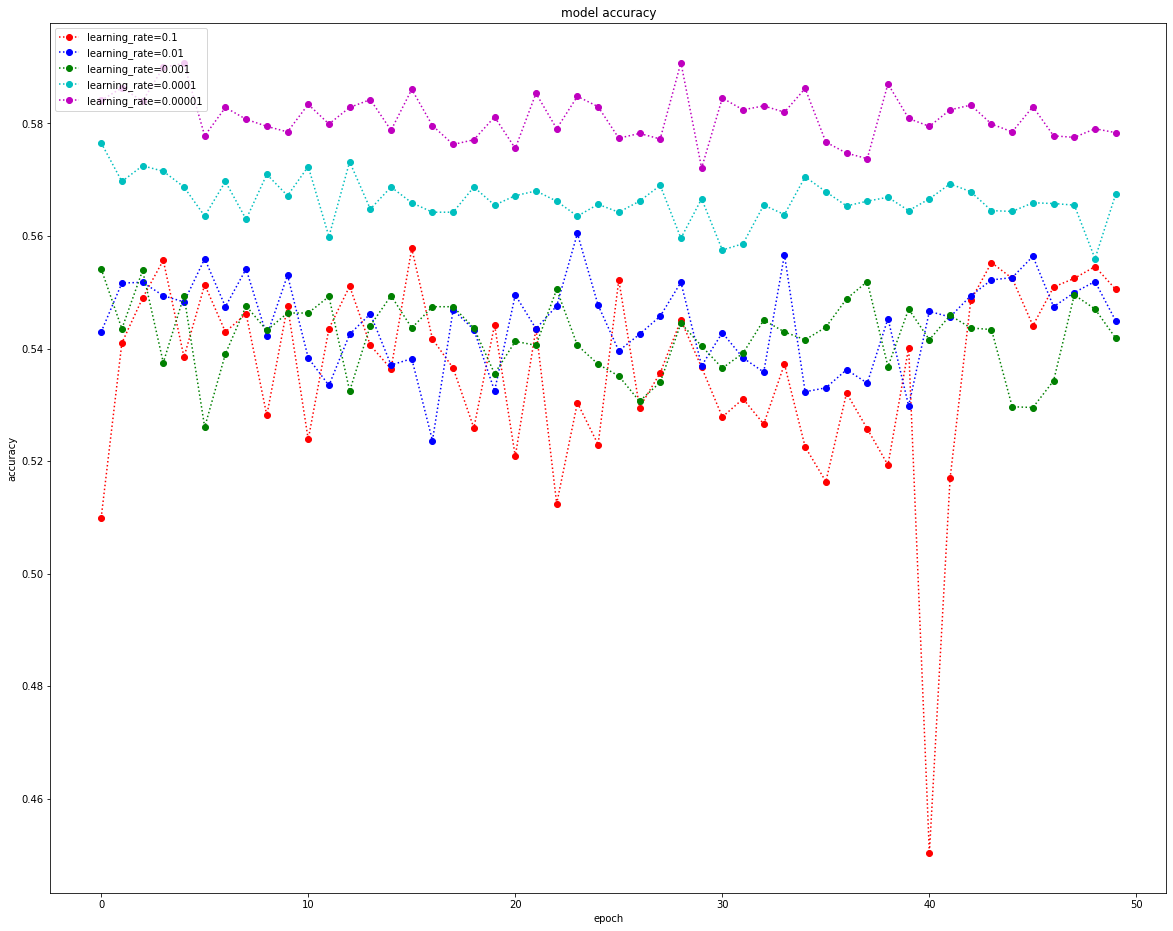

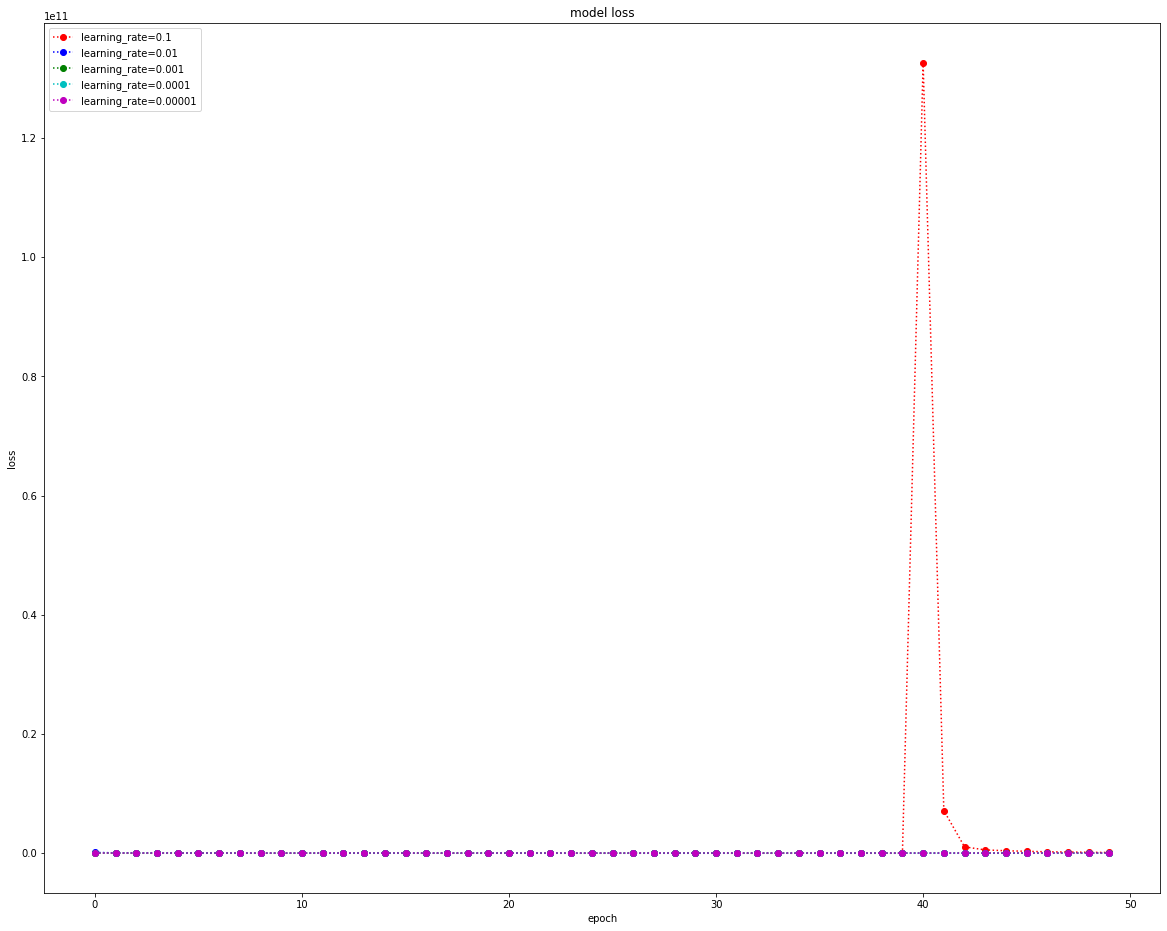

In [28]:
plt.rcParams["figure.figsize"] = (20,16)
plt.plot(history_01.history['accuracy'] ,'o:r')
plt.plot(history_001.history['accuracy'] ,'o:b')
plt.plot(history_0001.history['accuracy'] ,'o:g')
plt.plot(history_1E_5.history['accuracy'] ,'o:c')
plt.plot(history_1E_6.history['accuracy'] ,'o:m')




plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['learning_rate=0.1',"learning_rate=0.01","learning_rate=0.001","learning_rate=0.0001","learning_rate=0.00001","learning_rate=0.000001"], loc='upper left')
plt.show()







# summarize history for loss
plt.plot(history_01.history['loss'] ,'o:r')
plt.plot(history_001.history['loss'] ,'o:b')
plt.plot(history_0001.history['loss'] ,'o:g')
plt.plot(history_1E_5.history['loss'] ,'o:c')
plt.plot(history_1E_6.history['loss'] ,'o:m')





plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['learning_rate=0.1',"learning_rate=0.01","learning_rate=0.001","learning_rate=0.0001","learning_rate=0.00001","learning_rate=0.000001"], loc='upper left')
plt.show()

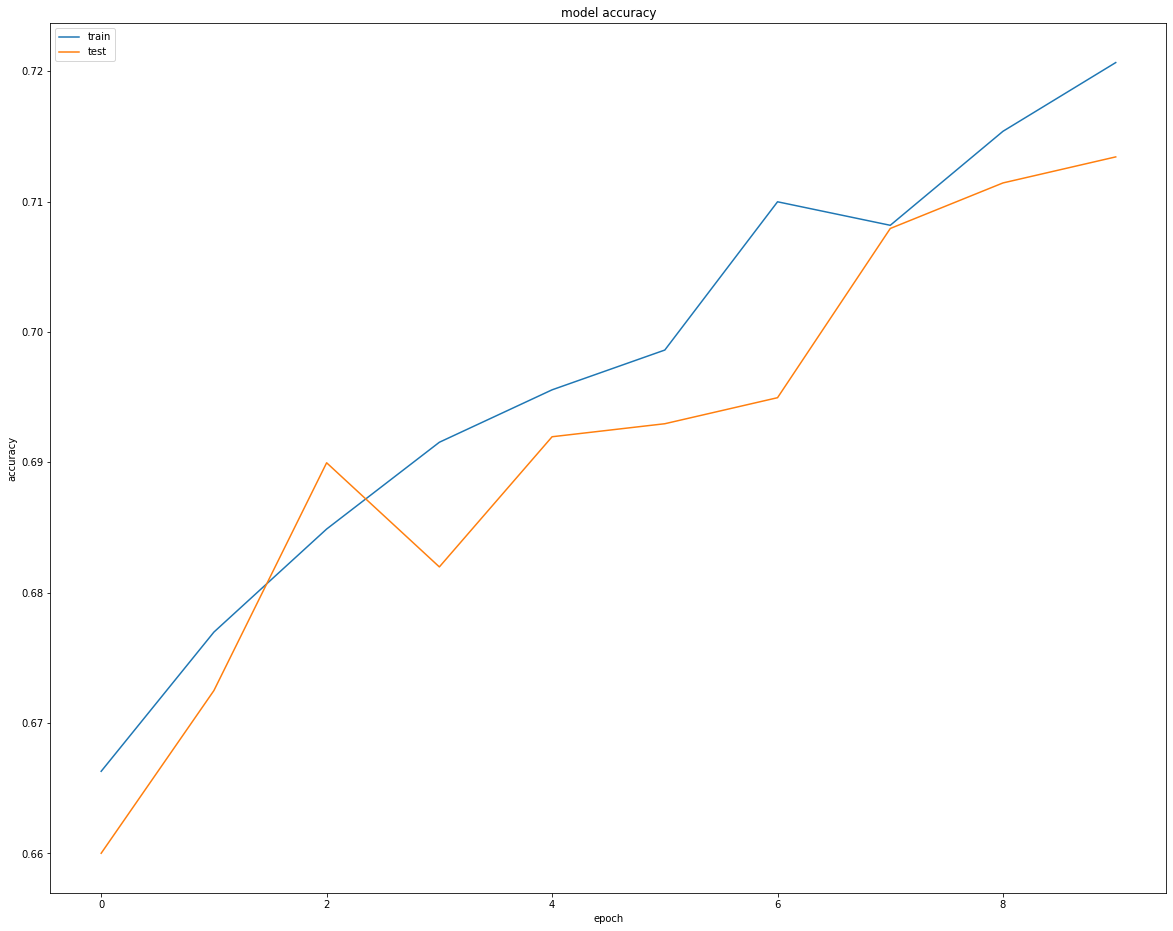

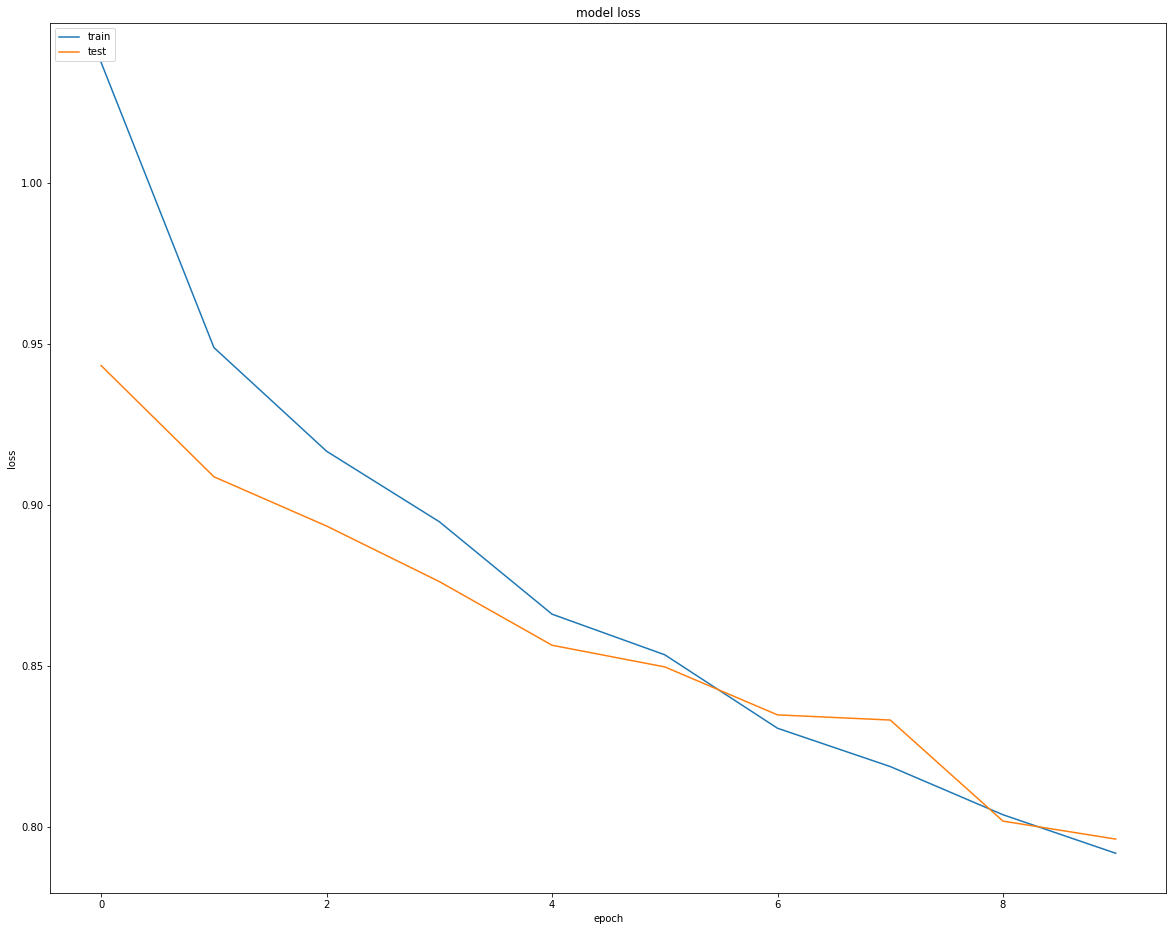

In [44]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()